<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/CNN2D_78_features_split_70_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection using CNN2D for CICIDS 2017 Data Set with 78 Features

We use the pre-processing dataset with data split 70:15:15. In this case, we do not use SMOTE to add more anomalies. 

In [1]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def display_metrics(y_test, y_pred, label_names):
  print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

  print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
  print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
  print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

  print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
  print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

  print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

  print('\nClassification Report\n')
  print(classification_report(y_test, y_pred, target_names=label_names))

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        print(df)

In [4]:
def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d

In [5]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

## Step 1. Loading csv files

In [6]:
# All columns
col_names = np.array(['dst sport count', 'src dport count', 'dst src count', 'dport count', 'sport count', 'dst host count','src host count','Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label'])

### Option 1. Connect to Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# load three csv files generated by mlp4nids (Multi-layer perceptron for network intrusion detection )
# first load the train set
df_train = pd.read_csv('/content/drive/My Drive/CICIDS2017/train_set_ext78_2.csv',names=col_names, skiprows=1)  

In [9]:
print('Train set size: ', df_train.shape)

Train set size:  (879589, 79)


In [10]:
df_test = pd.read_csv('/content/drive/My Drive/CICIDS2017/test_set_ext78_2.csv',names=col_names, skiprows=1)  
print('Test set size: ', df_test.shape)

df_val = pd.read_csv('/content/drive/My Drive/CICIDS2017/crossval_set_ext78_2.csv',names=col_names, skiprows=1)  
print('Validation set size: ', df_val.shape)

Test set size:  (188483, 79)
Validation set size:  (188484, 79)


### Option 2. Load from local machine

In [ ]:
dataroot = '../data/cicids2017clean/train_set_ext78.csv'
df_train = pd.read_csv(dataroot, names=col_names, skiprows=1) 

In [ ]:
dataroot = '../data/cicids2017clean/crossval_set_ext78.csv'
df_val = pd.read_csv(dataroot, names=col_names, skiprows=1) 
dataroot = '../data/cicids2017clean/test_set_ext78.csv'
df_test = pd.read_csv(dataroot, names=col_names, skiprows=1) 

## Step 2. Exploring the dataset

In [ ]:
df_train.head()

,dst sport count,src dport count,dst src count,dport count,sport count,dst host count,src host count,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
480307,1,36,36,48,1,48,81,56014,53,17,60843,2,2,94,226,47,47,47.0,0.0,113,113,113.0,0.0,5259.438226,65.742978,20281.0,3.512166e+04,60836,3,3,3.0,0.000,3,3,4,4.0,0.0,4,4,0,0,40,40,32.871489,32.871489,47,113,73.400000,36.149689,1306.800000,0,0,0,0,0,0,0,0,1,91.75,47.0,113.0,2,94,2,226,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2273904,1,96,96,96,1,96,96,33606,80,6,2,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000,1000000.000000,2.0,0.000000e+00,2,2,2,2.0,0.000,2,2,0,0.0,0.0,0,0,0,0,64,0,1000000.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.00,0.0,0.0,2,0,0,0,251,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
2173332,1,1,1,26,1,1,1,54288,80,6,44,1,1,8,0,8,8,8.0,0.0,0,0,0.0,0.0,181818.181800,45454.545450,44.0,0.000000e+00,44,44,0,0.0,0.000,0,0,0,0.0,0.0,0,0,1,0,32,32,22727.272730,22727.272730,0,8,5.333333,4.618802,21.333333,0,1,0,0,1,0,0,0,1,8.00,8.0,0.0,1,8,1,0,229,235,0,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS slowloris
2267207,1,100,100,100,1,100,100,50768,80,6,2,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000,1000000.000000,2.0,0.000000e+00,2,2,2,2.0,0.000,2,2,0,0.0,0.0,0,0,0,0,64,0,1000000.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.00,0.0,0.0,2,0,0,0,251,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
90817,1,100,100,100,1,100,100,62083,80,6,3795333,4,0,24,0,6,6,6.0,0.0,0,0,0.0,0.0,6.323556,1.053926,1265111.0,2.190632e+06,3794635,348,3795333,1265111.0,2190632.043,3794635,348,0,0.0,0.0,0,0,0,0,80,0,1.053926,0.000000,6,6,6.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,7.50,6.0,0.0,4,24,0,0,256,-1,3,20,0.0,0.0,0,0,0.0,0.0,0,0,DDoS


Count the number of attacks

In [ ]:
df_train['Label'].value_counts()

BENIGN                        278274
DoS Hulk                      115062
PortScan                       79402
DDoS                           64012
DoS GoldenEye                   5146
FTP-Patator                     3967
SSH-Patator                     2948
DoS slowloris                   2898
DoS Slowhttptest                2749
Bot                              978
Web Attack � Brute Force         753
Web Attack � XSS                 326
Infiltration                      18
Web Attack � Sql Injection        10
Heartbleed                         5
Name: Label, dtype: int64

In [ ]:
df_train.describe()

,dst sport count,src dport count,dst src count,dport count,sport count,dst host count,src host count,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,5.565480e+05,556548.000000,556548.000000,5.565480e+05,5.565480e+05,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,556548.000000,556548.0,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,556548.000000,556548.000000,556548.000000,556548.000000,5.565480e+05,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.0,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,5.565480e+05,556548.000000,5.565480e+05,556548.000000,556548.000000,556548.000000,556548.000000,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05,5.565480e+05
mean,17.404549,45.110869,61.974631,50.221837,18.182408,63.986114,71.911368,41059.562686,7182.692884,8.358620,2.159931e+07,7.561386,8.259167,6.822941e+02,1.265955e+04,336.406078,18.889621,96.200260,129.272466,1702.530853,25.598678,561.627492,704.125544,9.216068e+05,6.956671e+04,2.010454e+06,5.303410e+06,1.768824e+07,2.166928e+05,2.114477e+07,3.910157e+06,6.895611e+06,1.747174e+07,8.147458e+05,1.071441e+07,1.973938e+06,2.677833e+06,7.299100e+06,6.975517e+05,0.034874,0.0,1.884306e+02,1.994029e+02,6.190488e+04,7.797160e+03,10.577194,1918.313215,308.111075,606.701378,1.260081e+06,0.056247,0.034874,0.000119,0.360393,0.371772,0.093363,0.0,0.000119,0.813482,340.208877,96.200260,561.627492,7.561386,6.822941e+02,8.259167,1.266110e+04,5913.062827,1109.007953,4.883591,25.540766,1.082361e+05,3.242660e+04,1.571849e+05,8.865328e+04,1.640646e+07,1.206008e+06,1.730500e+07,1.552621e+07
std,35.384468,42.638613,42.602329,41.628146,35.613865,40.704131,36.408934,20762.257722,16999.053361,4.518634,3.824665e+07,641.917381,865.356666,8.207379e+03,1.934124e+06,1243.294768,107.276928,334.915124,524.220046,2851.196636,57.820679,873.686322,1254.293604,2.225586e+07,2.632438e+05,5.270740e+06,1.018751e+07,3.380225e+07,3.879389e+06,3.830840e+07,9.825054e+06,1.406852e+07,3.407836e+07,7.862357e+06,2.923981e+07,8.267067e+06,8.952940e+06,2.272525e+07,7.091812e+06,0.183461,0.0,1.350587e+04,1.735201e+04,2.542560e+05,4.220304e+04,21.863457,2990.143762,434.674128,944.496729,2.616912e+06,0.230398,0.183461,0.010889,0.480115,0.483278,0.290941,0.0,0.010889,1.011007,477.689108,334.915124,873.686322,641.917381,8.207379e+03,865.356666,1.934497e+06,11687.758097,6328.829096,612.739185,6.418384,7.164700e+0

Read test and validation sets

In [ ]:
print('Test set: ')
df_test['Label'].value_counts()

Test set: 


BENIGN                        139135
DoS Hulk                       57531
PortScan                       39701
DDoS                           32006
DoS GoldenEye                   2573
FTP-Patator                     1983
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1374
Bot                              489
Web Attack � Brute Force         376
Web Attack � XSS                 163
Infiltration                       9
Web Attack � Sql Injection         5
Heartbleed                         3
Name: Label, dtype: int64

In [ ]:
df_test.describe()

,dst sport count,src dport count,dst src count,dport count,sport count,dst host count,src host count,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,278271.000000,278271.000000,2.782710e+05,2.782710e+05,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,278271.000000,278271.0,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.0,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,278271.000000,2.782710e+05,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05
mean,9.211463,41.570207,50.670494,48.520629,9.784523,51.894815,57.833299,45364.904518,5840.614247,7.480744,2.018529e+07,13.435784,15.078546,5.018634e+02,2.779896e+04,185.099425,9.858092,42.498201,62.543363,1437.960556,16.702765,473.001490,598.923602,1.319686e+06,9.153057e+04,2.091047e+06,4.928250e+06,1.541150e+07,2.118994e+05,1.981751e+07,4.173268e+06,5.569083e+06,1.522482e+07,1.619351e+06,1.058734e+07,2.418266e+06,2.028890e+06,6.305782e+06,1.360560e+06,0.055008,0.0,3.187151e+02,3.386415e+02,8.541129e+04,6.162402e+03,7.706930,1472.204682,241.337407,466.829902,8.970517e+05,0.058659,0.055008,0.000079,0.423418,0.383939,0.024473,0.0,0.000079,0.515483,266.234398,42.498201,473.001490,13.435784,5.018634e+02,15.078546,2.779896e+04,10570.884347,1731.262503,10.077360,26.450597,9.950222e+04,4.357586e+04,1.635857e+05,7.265751e+04,1.389971e+07,9.310308e+05,1.461178e+07,1.319741e+07
std,24.647299,40.590060,44.031142,38.853900,24.819060,43.062668,38.657248,17986.019121,15731.016163,3.759342,3.747712e+07,1208.787882,1591.038780,7.898141e+03,3.604988e+06,392.757821,61.235870,99.578078,132.298360,2586.575823,46.983450,797.849156,1144.524019,2.365350e+07,2.939535e+05,5.446982e+06,1.046404e+07,3.156535e+07,3.035599e+06,3.741901e+07,1.178048e+07,1.262894e+07,3.161068e+07,1.066531e+07,2.913390e+07,1.045180e+07,7.731514e+06,2.046626e+07,9.752983e+06,0.227995,0.0,2.524817e+04,3.182483e+04,2.889880e+05,3.511575e+04,17.933281,2584.423333,383.122237,824.119425,2.290050e+06,0.234985,0.227995,0.008891,0.494101,0.486344,0.154511,0.0,0.008891,0.551013,420.656447,99.578078,797.849156,1208.787882,7.898141e+03,1591.038780,3.604988e+06,17759.995598,7434.271819,1153.406441,6.864560,7.423949e

In [ ]:
print('Validation set: ')
df_val['Label'].value_counts()

Validation set: 


BENIGN                        139135
DoS Hulk                       57531
PortScan                       39701
DDoS                           32006
DoS GoldenEye                   2573
FTP-Patator                     1983
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1374
Bot                              489
Web Attack � Brute Force         376
Web Attack � XSS                 163
Infiltration                       9
Web Attack � Sql Injection         5
Heartbleed                         3
Name: Label, dtype: int64

In [ ]:
df_val.describe()

,dst sport count,src dport count,dst src count,dport count,sport count,dst host count,src host count,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,278271.000000,278271.000000,278271.000000,2.782710e+05,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,278271.000000,278271.0,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.0,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,278271.000000,2.782710e+05,278271.000000,278271.000000,278271.000000,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05,2.782710e+05
mean,1.990998,42.802930,54.780786,50.547276,2.597942,57.510987,64.362470,42404.667202,4584.269256,8.772351,2.267721e+07,5.699268,5.402618,363.353856,6.999757e+03,146.291342,12.216839,37.118863,48.506942,1644.047109,31.044874,545.032382,677.307354,1.026165e+06,7.647809e+04,2.035285e+06,5.660109e+06,1.867977e+07,1.176204e+05,2.242948e+07,4.097957e+06,7.275873e+06,1.857571e+07,8.532087e+05,1.033249e+07,2.108772e+06,2.497462e+06,6.852247e+06,8.777074e+05,0.032285,0.0,-1.853571e+04,-6.184714e+03,6.922891e+04,7.292895e+03,11.819061,1667.716693,265.854571,521.028142,1.032927e+06,0.063621,0.032285,0.000111,0.325007,0.360620,0.052697,0.0,0.000111,0.635187,293.534471,37.118863,545.032382,5.699268,363.353856,5.402618,7.000217e+03,8300.325388,1196.875402,2.850685,-6.302902e+03,1.011659e+05,3.866514e+04,1.584026e+05,7.772891e+04,1.758371e+07,9.337383e+05,1.829748e+07,1.689399e+07
std,4.265641,41.155317,42.944530,39.930140,6.159142,40.985881,37.588853,18921.287989,13260.472293,4.780471,3.957510e+07,67.151481,87.170488,3246.935490,2.585745e+05,380.926394,29.589599,80.881136,118.838807,2798.418936,63.404220,851.958641,1229.568867,1.848893e+07,2.733851e+05,4.353746e+06,1.081617e+07,3.532604e+07,1.940209e+06,3.955400e+07,9.992200e+06,1.450106e+07,3.536578e+07,7.979549e+06,2.928687e+07,9.212518e+06,9.080348e+06,2.268128e+07,8.098556e+06,0.176757,0.0,4.255032e+06,8.563310e+05,2.681762e+05,3.540812e+04,21.282900,2802.082031,395.041283,872.654915,2.337813e+06,0.244078,0.176757,0.010554,0.468378,0.480181,0.223428,0.0,0.010554,0.543604,431.315008,80.881136,851.958641,67.151481,3246.935490,87.170488,2.586262e+05,13668.049447,6710.071455,32.991288,7.286956e+05,8.404500e+05,4.48734

## Step 3. Encode Datasets

Encoding the labels, and generate numpy array. Note that the label has not been encoded as one-hot coding. We will use one-hot code later. 

### Step 3.1 Encoding train dataset

In [11]:
df_label = df_train['Label']
data = df_train.drop(columns=['Label'])
Xtrain = data.values
y_train = encode_label(df_label.values)

### Step 3.2. Encoding test dataset

In [12]:
df_label = df_test['Label']
data = df_test.drop(columns=['Label'])
Xtest = data.values
y_test = encode_label(df_label.values)

### Step 3.3 Encoding validation dataset

In [13]:
df_label = df_val['Label']
data = df_val.drop(columns=['Label'])
Xval = data.values
y_val = encode_label(df_label.values)

## Step 4. Normalization or Standardization

The continuous feature values are normalized into the same feature space. This is important when using features that have different measurements, and is a general requirement of many machine learning algorithms. We implement the two methods to see the impact on the final classifications. 

## Option 1. Normalization

The values of the datasets are normalized using the Min-Max scaling technique, bringing them all within a range of [0,1].

### Step 4.1 Normalizing train dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(Xtrain)
X_train

array([[7.66048676e-01, 5.93603125e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.29167620e-01, 1.22077764e-03, 3.52941176e-01, ...,
        0.00000000e+00, 7.12500000e-01, 7.12500000e-01],
       [7.86144808e-01, 6.76005616e-03, 3.52941176e-01, ...,
        8.96864890e-03, 4.90833333e-01, 4.83333333e-01],
       ...,
       [2.53009842e-01, 1.22077764e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.85610742e-01, 8.08765183e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.26276036e-01, 1.22077764e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Step 4.2. Normalizing validation dataset

In [ ]:
X_val = scaler.fit_transform(Xval)
X_val

array([[4.37994965e-01, 1.22344737e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.41290913e-01, 6.12488339e-02, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.87327382e-02, 6.77483980e-03, 3.52941176e-01, ...,
        5.68691207e-05, 8.33333333e-02, 8.32947583e-02],
       ...,
       [9.30510414e-01, 8.10533882e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.50492103e-01, 8.68494701e-02, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.24353399e-01, 1.22344737e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Step 4.3. Normalizing test dataset

In [ ]:
X_test = scaler.fit_transform(Xtest)
X_test

array([[5.45487838e-01, 9.66383862e-01, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.17142247e-01, 1.22074038e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.92001099e-01, 7.97448653e-02, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.04507584e-01, 1.22074038e-03, 3.52941176e-01, ...,
        0.00000000e+00, 8.33370661e-01, 8.33370661e-01],
       [9.22345653e-01, 8.08740501e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.45030061e-01, 6.75984985e-03, 3.52941176e-01, ...,
        5.01804492e-03, 4.88761059e-01, 4.84412289e-01]])

## Option 2. Standardization

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()

X_train = scaler.fit_transform(Xtrain)
X_val = scaler.fit_transform(Xval)
X_test = scaler.fit_transform(Xtest)

X_train

array([[-0.29659729,  1.51710965,  1.13640038, ...,  8.4581104 ,
         2.22140524, -0.0393603 ],
       [-0.29659729, -0.36301636, -0.83451004, ..., -0.13390608,
        -0.45746381, -0.43398332],
       [-0.33534125, -0.87577799, -1.06105146, ..., -0.13390608,
        -0.45746381, -0.43398332],
       ...,
       [-0.33534125, -0.60718856, -0.83451004, ..., -0.13390608,
        -0.45746381, -0.43398332],
       [-0.33534125,  1.224103  ,  0.86455067, ..., -0.13390608,
        -0.45746381, -0.43398332],
       [ 3.50031109, -0.90019522,  1.13640038, ..., -0.13390608,
        -0.45746381, -0.43398332]])

## Step 5 One-hot encoding for labels

y_train, y_test and y_val have to be one-hot-encoded. That means they must have dimension (number_of_samples, 15), where 15 denotes number of classes.

In [16]:
from tensorflow.keras.utils import to_categorical

Save the labels for AdaBoostClassifier

In [17]:
y_train_ada = y_train
y_test_ada = y_test
y_val_ada = y_val

In [18]:
y_train = to_categorical(y_train, 15)
y_test = to_categorical(y_test, 15)
y_val = to_categorical(y_val, 15)

## Step 6. Define the metrics

In [19]:
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier

#importing confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn import metrics
from sklearn.metrics import accuracy_score

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [20]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

Get the attacks' names

In [21]:
labels_d = make_value2index(df_test['Label'])

In [22]:
print(labels_d)

{'BENIGN': 105018, 'Bot': 105298, 'DDoS': 124569, 'DoS GoldenEye': 126111, 'DoS Hulk': 160658, 'DoS Slowhttptest': 161486, 'DoS slowloris': 162320, 'FTP-Patator': 163498, 'Heartbleed': 163500, 'Infiltration': 163501, 'PortScan': 187347, 'SSH-Patator': 188173, 'Web Attack � Brute Force': 188382, 'Web Attack � Sql Injection': 188389, 'Web Attack � XSS': 188482}


# CNN2D Model 

Convert each example as a 6x13 gray image since each example has 78 features.  

In [23]:
img_row = 6
img_col = 13

X_train_gray = np.array([x.reshape(img_row, img_col,1) for x in X_train])
train_gray = np.array([x.reshape(img_row, img_col) for x in X_train])

In [24]:
X_test_gray = np.array([x.reshape(img_row, img_col,1) for x in X_test])
test_gray = np.array([x.reshape(img_row, img_col) for x in X_test])

In [25]:
X_val_gray = np.array([x.reshape(img_row, img_col,1) for x in X_val])
val_gray =  np.array([x.reshape(img_row, img_col) for x in X_val])

In [26]:
X_train_gray.shape

(879589, 6, 13, 1)

In [27]:
X_test_gray.shape

(188483, 6, 13, 1)

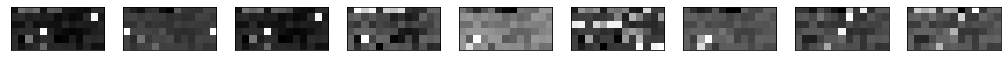

In [ ]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(train_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

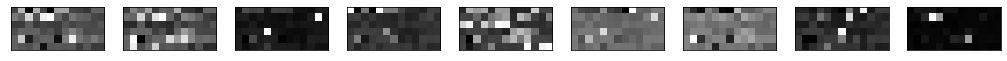

In [ ]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

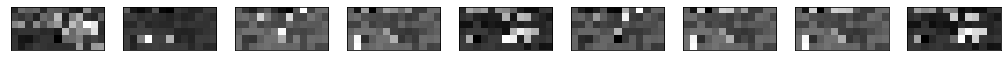

In [ ]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(val_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [29]:
#hyper-params
batch_size =2048 # increasing batch size with more gpu added
input_dim = X_train.shape[1]
num_class = 15                   # 15 intrusion classes, including benign traffic class
num_epochs = 30
learning_rates = 1e-4
regularizations = 1e-3
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

print(input_dim)
print(num_class)

78
15


In [30]:
model2d_g = Sequential()
model2d_g.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(6,13,1)))
model2d_g.add(Conv2D(64, kernel_size=(3 ,3), padding='same',  activation='relu'))
model2d_g.add(Conv2D(128, kernel_size=(3,3), padding='same',  activation='relu'))
model2d_g.add(Flatten())
model2d_g.add(Dropout(0.2))
model2d_g.add(Dense(512))
model2d_g.add(Dense(num_class, activation='softmax'))
 
model2d_g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 13, 32)         320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 13, 64)         18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 13, 128)        73856     
_________________________________________________________________
flatten (Flatten)            (None, 9984)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9984)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               5112320   
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7

In [31]:
from keras.optimizers import Nadam, Adam, RMSprop
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import keras
import time
time_start = time.time()

reduce_lr = keras.callbacks.ReduceLROnPlateau(moniter='val_loss',
                                              factor=0.1,
                                              patience=10)
nadam = Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.0001)
model2d_g.compile(loss = "categorical_crossentropy",optimizer = "nadam", metrics = METRICS)
#model2d_g.compile(loss='categorical_crossentropy',
#              optimizer= RMSprop(lr=0.001), #,SGD(lr=0.01), #
#              metrics=METRICS)

#model2d_g.compile(
#      optimizer= Adam(lr=1e-4),
#      loss=tf.keras.losses.BinaryCrossentropy(),
#      loss='categorical_crossentropy',
#      metrics=METRICS)

history = model2d_g.fit(X_train_gray, y_train, 
                    epochs=40, 
                    batch_size=batch_size, 
                    verbose=2,
                    validation_data=(X_val_gray, y_val),
                    callbacks=[reduce_lr])
time_end = time.time()
train_time = time_end - time_start
print("train_time:",train_time)

Epoch 1/40
430/430 - 63s - loss: 0.0875 - tp: 853674.0000 - fp: 17089.0000 - tn: 12297157.0000 - fn: 25915.0000 - accuracy: 0.9967 - precision: 0.9804 - recall: 0.9705 - auc: 0.9990 - val_loss: 0.0351 - val_tp: 186235.0000 - val_fp: 2128.0000 - val_tn: 2636648.0000 - val_fn: 2249.0000 - val_accuracy: 0.9985 - val_precision: 0.9887 - val_recall: 0.9881 - val_auc: 0.9998
Epoch 2/40
430/430 - 52s - loss: 0.0309 - tp: 870306.0000 - fp: 8658.0000 - tn: 12305588.0000 - fn: 9283.0000 - accuracy: 0.9986 - precision: 0.9901 - recall: 0.9894 - auc: 0.9998 - val_loss: 0.0253 - val_tp: 186840.0000 - val_fp: 1597.0000 - val_tn: 2637179.0000 - val_fn: 1644.0000 - val_accuracy: 0.9989 - val_precision: 0.9915 - val_recall: 0.9913 - val_auc: 0.9999
Epoch 3/40
430/430 - 53s - loss: 0.0246 - tp: 872016.0000 - fp: 7266.0000 - tn: 12306980.0000 - fn: 7573.0000 - accuracy: 0.9989 - precision: 0.9917 - recall: 0.9914 - auc: 0.9999 - val_loss: 0.0223 - val_tp: 187059.0000 - val_fp: 1371.0000 - val_tn: 2637405

KeyboardInterrupt: ignored

## Get the metrics

In [32]:
# evaluate model
accuracy = model2d_g.evaluate(X_test_gray, y_test, batch_size=batch_size, verbose=1)

93/93 [==============================] - 4s 42ms/step - loss: 0.0154 - tp: 187460.0000 - fp: 998.0000 - tn: 2637764.0000 - fn: 1023.0000 - accuracy: 0.9993 - precision: 0.9947 - recall: 0.9946 - auc: 0.9999


In [33]:
y_pred=model2d_g.predict(X_test_gray)

In [34]:
display_metrics(y_test_ada, np.argmax(y_pred, axis = 1), labels_d)


Accuracy: 0.99

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.83
Macro Recall: 0.84
Macro F1-score: 0.83

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

Classification Report

                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      1.00    105019
                       Bot       0.93      0.99      0.96       280
                      DDoS       1.00      1.00      1.00     19271
             DoS GoldenEye       1.00      0.99      0.99      1542
                  DoS Hulk       1.00      1.00      1.00     34547
          DoS Slowhttptest       1.00      0.99      0.99       828
             DoS slowloris       0.99      0.99      0.99       834
               FTP-Patator       1.00      0.99      1.00      1178
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       0.00      0.00      0.00         1
                  PortScan       0.97      0.99      0.98     23846
               SSH-Patato

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
